## Table of Contents

### 1. Data Loading and Preprocessing
> #### 1.1 Load the Data
> #### 1.2 Define custom dataset and dataloader
> #### 1.3 Data Exploration
### 2. Lane Segmentation using Baseline U-Net
> #### 2.1 Define model architecture
> #### 2.2 Train the model
> #### 2.3 Calculate IoU score
### 3. Lane Segmentation using U-Net with Best practices
> #### 3.0 Define validation and test dataloader
> #### 3.1 Define model architecture
> #### 3.2 Train the model
> #### 3.3 Calculate IoU score
> #### 3.4 Inference on Test dataset

---

### 1. Data Loading and Preprocessing

#### 1.1 Load the Data

In [ ]:
# Upload data from drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip /content/drive/MyDrive/Image_Segmentation/camVidzip.zip

Archive:  /content/drive/MyDrive/Image_Segmentation/camVidzip.zip
  inflating: data/CamVid/test/0001TP_008550.png  
  inflating: data/CamVid/test/0001TP_008580.png  
  inflating: data/CamVid/test/0001TP_008610.png  
  inflating: data/CamVid/test/0001TP_008640.png  
  inflating: data/CamVid/test/0001TP_008670.png  
  inflating: data/CamVid/test/0001TP_008700.png  
  inflating: data/CamVid/test/0001TP_008730.png  
  inflating: data/CamVid/test/0001TP_008760.png  
  inflating: data/CamVid/test/0001TP_008790.png  
  inflating: data/CamVid/test/0001TP_008820.png  
  inflating: data/CamVid/test/0001TP_008850.png  
  inflating: data/CamVid/test/0001TP_008880.png  
  inflating: data/CamVid/test/0001TP_008910.png  
  inflating: data/CamVid/test/0001TP_008940.png  
  inflating: data/CamVid/test/0001TP_008970.png  
  inflating: data/CamVid/test/0001TP_009000.png  
  inflating: data/CamVid/test/0001TP_009030.png  
  inflating: data/CamVid/test/0001TP_009060.png  
  inflating: data/CamVid/test/0001

In [ ]:
!pip install -U segmentation-models-pytorch
#https://github.com/qubvel/segmentation_models.pytorch
#pip install git+https://github.com/qubvel/segmentation_models.pytorch latest version

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=46a38fc6a77d37ce56df2421f25c62d1618ee3a11bd355ec5fbb4e06c7827197
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=17da21ec4a59585f903a370d231d7cbbbbdd4f3aa00493eac2dd6dcb3b312eac
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

In [ ]:
# import libraries and modules
%matplotlib inline

import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from random import random

# import pytorch related modules
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as F
from torchvision.transforms import Compose, ToTensor, Resize, Normalize

import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils

In [ ]:
# set seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed);

In [ ]:
x_train_dir = '/content/data/CamVid/train'
y_train_dir = '/content/data/CamVid/trainannot'

x_val_dir = '/content/data/CamVid/val'
y_val_dir = '/content/data/CamVid/valannot'

x_test_dir = '/content/data/CamVid/test'
y_test_dir = '/content/data/CamVid/testannot'

## Code With Comments

```python
# Import necessary libraries
import os
from PIL import Image
import numpy as np
from torch.utils.data import Dataset
from torchvision.transforms import functional as F
from random import random
from torchvision.transforms import Compose, Normalize

# Define a custom dataset class for CamVid dataset
class CamVidDataset(Dataset):
    def __init__(self, images_dir, masks_dir=None, transforms=None, preprocessing=False, training_type=None):
        """
        Initialize the CamVidDataset.

        Args:
            images_dir (str): Path to the directory containing images.
            masks_dir (str, optional): Path to the directory containing masks. Defaults to None.
            transforms (callable, optional): Transformations to be applied to images/masks. Defaults to None.
            preprocessing (bool, optional): Flag to apply preprocessing. Defaults to False.
            training_type (str, optional): Specifies 'train', 'val', or 'test' mode. Defaults to None.
        """
        # Get all image filenames from the images directory
        self.image_names = os.listdir(images_dir)

        # Save the training type and transforms
        self.training_type = training_type
        self.transforms = transforms
        self.preprocessing = preprocessing

        # Initialize lists to hold the full paths of images and masks
        self.images_paths = []
        self.masks_paths = []

        # Loop through all image filenames to construct their full paths
        for image_name in self.image_names:
            # Construct full image path
            self.images_paths.append(os.path.join(images_dir, image_name))

            # If in 'train' or 'val' mode, construct full mask path
            if self.training_type in ["train", "val"]:
                # Replace image extension with '.png' for mask filenames
                self.masks_paths.append(os.path.join(masks_dir, image_name.split('.')[0] + '.png'))

    def __getitem__(self, i):
        """
        Get a single dataset item (image and optionally mask).

        Args:
            i (int): Index of the item to fetch.

        Returns:
            Tuple (image, mask) for 'train'/'val' or image only for 'test'.
        """
        if self.training_type in ["train", "val"]:
            # Read the image and mask using PIL
            image = Image.open(self.images_paths[i])
            mask = Image.open(self.masks_paths[i])

            # Convert mask to a NumPy array and create a binary mask where label 3 is True
            mask = np.array(mask)
            mask = (mask == 3)  # Binary mask where label 3 is set to True
            mask = Image.fromarray(mask)  # Convert back to PIL format

            # Data augmentation: apply random horizontal flip with 50% probability
            if random() < 0.5:
                image, mask = F.hflip(image), F.hflip(mask)

            # Apply transformations to both image and mask (e.g., resizing, normalization)
            image = self.transforms(image)
            mask = self.transforms(mask)

            # Apply preprocessing (e.g., normalization for pre-trained models)
            if self.preprocessing:
                image = Compose([Normalize(mean=[0.485, 0.456, 0.406],
                                           std=[0.229, 0.224, 0.225])])(image)

            # Return the transformed image and mask
            return image, mask

        else:  # For 'test' mode
            # Read the image using PIL
            image = Image.open(self.images_paths[i])

            # Apply transformations to the image
            image = self.transforms(image)

            # Apply preprocessing (e.g., normalization for pre-trained models)
            if self.preprocessing:
                image = Compose([Normalize(mean=[0.485, 0.456, 0.406],
                                           std=[0.229, 0.224, 0.225])])(image)

            # Return the transformed image
            return image

    def __len__(self):
        """
        Get the total number of items in the dataset.

        Returns:
            int: Number of images in the dataset.
        """
        return len(self.image_names)
```

#### 1.2 Define custom dataset and dataloader

In [ ]:
# define custom dataset class
class CamVidDataset(Dataset):
    def __init__(self, images_dir, masks_dir=None, transforms=None, preprocessing=False, training_type=None):
        # get all image names
        self.image_names = os.listdir(images_dir)

        # set training type, transforms
        self.training_type = training_type
        self.transforms = transforms
        self.preprocessing=preprocessing

        # get image and target paths
        self.images_paths = []
        self.masks_paths = []
        for image_name in self.image_names:
            self.images_paths.append(os.path.join(images_dir, image_name))
            if self.training_type=="train" or self.training_type=="val":
                self.masks_paths.append(os.path.join(masks_dir, image_name.split('.')[0] + '.png'))

    def __getitem__(self, i):

        if self.training_type=="train" or self.training_type=="val":
            # read data
            image = Image.open(self.images_paths[i])
            mask = Image.open(self.masks_paths[i])

            # preprocess mask
            mask = np.array(mask)
            mask = (mask == 3)
            mask = Image.fromarray(mask)

            # data augmentation
            ## random horizontal flip
            if random() < 0.5:
                image, mask = F.hflip(image), F.hflip(mask)

            ## apply transforms
            image = self.transforms(image)
            mask = self.transforms(mask)

            ## apply preprocessing
            if self.preprocessing:
                image = Compose([Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])])(image)

            return image, mask

        else:
            # read data
            image = Image.open(self.images_paths[i])

            # apply transforms
            image = self.transforms(image)

            # apply preprocessing
            if self.preprocessing:
                image = Compose([Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])])(image)

            return image

    def __len__(self):
        return len(self.image_names)

In [ ]:
# create transform
train_transforms = Compose([
    Resize((224, 224)),
    ToTensor()
])
# create instance of custom dataset
train_dataset = CamVidDataset(
    x_train_dir,
    y_train_dir,
    transforms=train_transforms,
    training_type='train'
)
# create dataloader
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    num_workers=4
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


#### 1.3 Data Exploration

In [ ]:
for batch_x, batch_y in train_loader:
    break

In [ ]:
batch_x.shape, batch_y.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16, 1, 224, 224]))

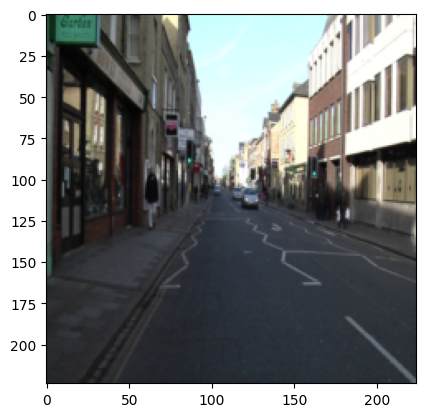

In [ ]:
plt.imshow(np.transpose(batch_x[0], (1, 2, 0)))

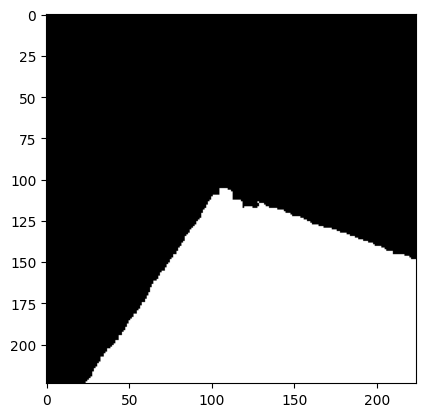

In [ ]:
plt.imshow(batch_y[0].squeeze(), cmap='gray')

In [ ]:
# create instance of custom dataset
train_dataset = CamVidDataset(
    x_train_dir,
    y_train_dir,
    transforms=train_transforms,
    preprocessing=True,
    training_type='train'
)
# create dataloader
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    num_workers=4
)

### 2. Lane Segmentation using Baseline U-Net


#### 2.1 Define model architecture

In [ ]:
# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name='resnet18',
    encoder_weights='imagenet',
    classes=1,
    activation='sigmoid',
)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 107MB/s]


In [ ]:
# print model
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
# check for one iteration of loop
for batch_x, batch_y in train_loader:
    break

In [ ]:
# check model on one image
model.eval()
output = model(batch_x[1].view(1, 3, 224, 224)).detach().numpy()

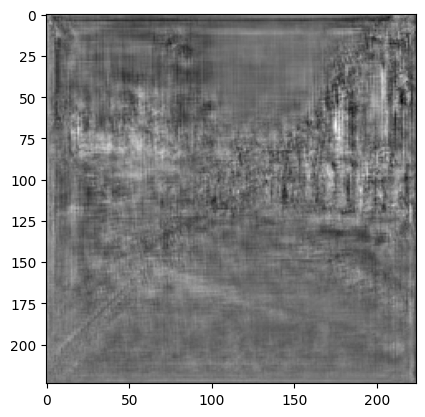

In [ ]:
# print output
plt.imshow(output.squeeze(), cmap='gray')

#### 2.2 Train the model

In [ ]:
# define loss function
criterion = smp.utils.losses.BCELoss()

# define optimizer
optimizer = torch.optim.Adam([parameters for parameters in model.parameters() if parameters.requires_grad], lr=1e-3)

# define evaluation metric
metrics = [
    smp.utils.metrics.IoU(threshold=0.5)
]

In [ ]:
# define training epoch
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=criterion,
    metrics=metrics,
    optimizer=optimizer,
    device='cuda',
    verbose=True,
)

In [ ]:
max_score = 0

for i in range(0, 5):
    print('\nEpoch: {}'.format(i + 1))
    train_logs = train_epoch.run(train_loader)


Epoch: 1
train: 100%|██████████| 23/23 [00:05<00:00,  3.92it/s, bce_loss - 0.2647, iou_score - 0.7972]

Epoch: 2
train: 100%|██████████| 23/23 [00:04<00:00,  5.10it/s, bce_loss - 0.09868, iou_score - 0.9164]

Epoch: 3
train: 100%|██████████| 23/23 [00:05<00:00,  4.21it/s, bce_loss - 0.0663, iou_score - 0.9379]

Epoch: 4
train: 100%|██████████| 23/23 [00:04<00:00,  5.26it/s, bce_loss - 0.05414, iou_score - 0.9449]

Epoch: 5
train: 100%|██████████| 23/23 [00:04<00:00,  5.28it/s, bce_loss - 0.04357, iou_score - 0.9549]


#### 2.3 Calculate IoU score

In [ ]:
# get sample data
image = Image.open('/content/data/CamVid/train/0006R0_f00930.png')
gt_mask = Image.open('/content/data/CamVid/trainannot/0006R0_f00930.png')

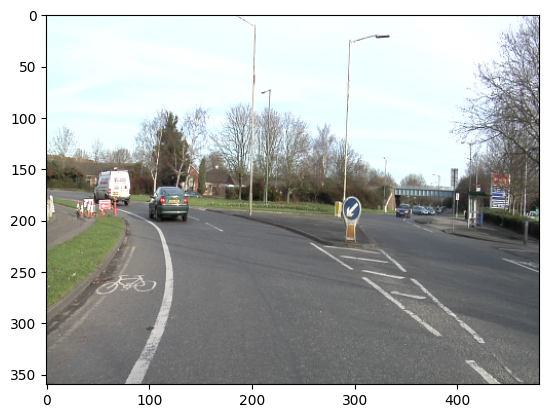

In [ ]:
plt.imshow(image)

In [ ]:
# preprocess mask
gt_mask = np.array(gt_mask)
gt_mask = (gt_mask == 3)
gt_mask = Image.fromarray(gt_mask)

# apply data augmentation
transform = Compose([
            Resize((224, 224)),
            ToTensor()
            ])

image = transform(image)

image = Compose([Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])])(image)

gt_mask = transform(gt_mask)

In [ ]:
model.eval()
output = model(image.view(1, 3, 224, 224).to("cuda")).cpu().detach().numpy()

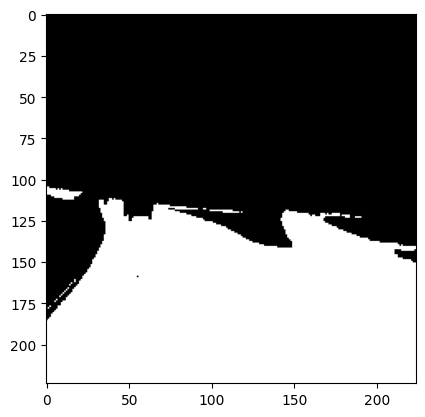

In [ ]:
plt.imshow(gt_mask.squeeze(), cmap='gray')

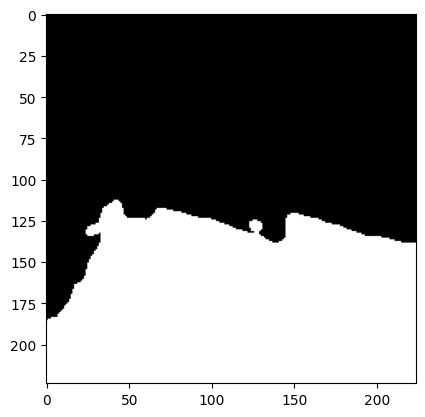

In [ ]:
plt.imshow((output.squeeze() > 0.5).astype(int), cmap='gray')

In [ ]:
# convert predicted mask to flattened numpy array
mask = (output.squeeze() > 0.5).astype(int)
pred = mask.ravel().copy()

# convert ground truth mask to flattened numpy array
gt_mask = gt_mask.cpu().detach().numpy()
target = gt_mask.ravel().copy().astype(int)

# get class indices for Lane
pred_inds = pred == 1
target_inds = target == 1

# calculate intersection
intersection = pred_inds[target_inds].sum()

# calculate union
union = pred_inds.sum() + target_inds.sum() - intersection

# get IoU score
iou = (float(intersection) / float(max(union, 1)))
iou

0.9541218293620292

### 3. Lane Segmentation using U-Net with Best Practices

#### 3.0 Define validation and test dataloaders

In [ ]:
train_transforms = Compose([
    Resize((224, 224)),
    ToTensor()
])
train_dataset = CamVidDataset(
    x_train_dir,
    y_train_dir,
    transforms=train_transforms,
    preprocessing=True,
    training_type='train'
)
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    num_workers=4
)

val_transforms = Compose([
    Resize((224, 224)),
    ToTensor()
])
val_dataset = CamVidDataset(
    x_val_dir,
    y_val_dir,
    transforms=val_transforms,
    preprocessing=True,
    training_type='val'
)
val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    num_workers=4
)

test_transforms = Compose([
    Resize((224, 224)),
    ToTensor()
])
test_dataset = CamVidDataset(
    x_test_dir,
    transforms=test_transforms,
    preprocessing=True,
    training_type='test'
)

#### 3.1 Define model architecture

In [ ]:
# Path to the manually downloaded weights file
weights_path = "/content/densenet121-fbdb23505.pth"

# Load the downloaded weights
encoder_weights = torch.load(weights_path)

# Create the U-Net model without automatic weight downloading
model = smp.Unet(
    encoder_name='densenet121',  # Use DenseNet121 as the encoder
    encoder_weights=None,        # Avoid downloading pretrained weights
    classes=1,                   # Number of output classes (e.g., for binary segmentation)
    activation='sigmoid',        # Activation function for the output layer
)

# Load the encoder weights into the model's encoder
model.encoder.load_state_dict(encoder_weights)


<ipython-input-34-d15eca004714>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder_weights = torch.load(weights_path)


In [ ]:
# create U-Net model with pretrained densenet
#model = smp.Unet(
    #encoder_name='densenet121',
    #encoder_weights='imagenet',
    #classes=1,
    #activation='sigmoid',
#)

In [ ]:
# Add the following line to the top of the file:
import ssl

# Then, wrap the `urlopen` call in a try-except block:
try:
    ssl._create_default_https_context = ssl._create_unverified_context
    model = smp.Unet(
        encoder_name='densenet121',
        encoder_weights='imagenet',
        classes=1,
        activation='sigmoid',
    )
except URLError as e:
    if isinstance(e.reason, ssl.SSLCertVerificationError):
        print("Error: Certificate has expired. Please renew your certificate or add it to the list of trusted certificates.")
    else:
        raise e

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/densenet121-fbdb23505.pth" to /root/.cache/torch/hub/checkpoints/densenet121-fbdb23505.pth
100%|██████████| 30.9M/30.9M [01:30<00:00, 356kB/s]


In [ ]:
# check for one iteration of loop
for batch_x, batch_y in train_loader:
    break

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# check model on one image
model.eval()
output = model(batch_x[1].view(1, 3, 224, 224)).detach().numpy()

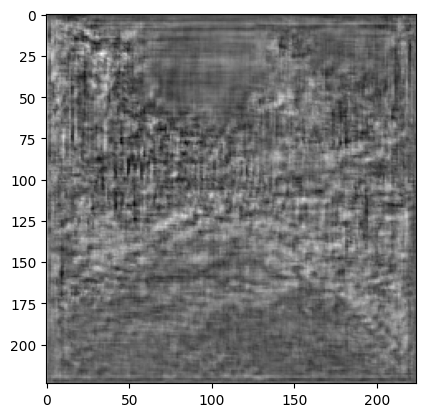

In [ ]:
# print output
plt.imshow(output.squeeze(), cmap='gray')

#### 3.2 Train the model

In [ ]:
# define loss function
criterion = smp.utils.losses.DiceLoss()

# define optimizer
optimizer = torch.optim.Adam([parameters for parameters in model.parameters() if parameters.requires_grad], lr=1e-3)

# define evaluation metric
metrics = [
    smp.utils.metrics.IoU(threshold=0.5)
]

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=criterion,
    metrics=metrics,
    optimizer=optimizer,
    device='cuda',
    verbose=True,
)

val_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=criterion,
    metrics=metrics,
    device='cuda',
    verbose=True,
)

In [ ]:
# saving best model
max_score = 0

for i in range(0, 15):
    print('\nEpoch: {}'.format(i + 1))
    train_logs = train_epoch.run(train_loader)
    val_logs = val_epoch.run(val_loader)

    if max_score < val_logs['iou_score']:
        max_score = val_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')

    # decreasing lr to fine tune model
    if i+1 == 10:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease learning rate to 1e-5')


Epoch: 1
valid: 100%|██████████| 7/7 [00:01<00:00,  5.00it/s, dice_loss - 0.2006, iou_score - 0.8647]
Model saved!

Epoch: 2
valid: 100%|██████████| 7/7 [00:02<00:00,  3.40it/s, dice_loss - 0.08443, iou_score - 0.9269]
Model saved!

Epoch: 3
valid: 100%|██████████| 7/7 [00:01<00:00,  4.93it/s, dice_loss - 0.055, iou_score - 0.9384]
Model saved!

Epoch: 4
valid: 100%|██████████| 7/7 [00:01<00:00,  4.70it/s, dice_loss - 0.04137, iou_score - 0.9449]
Model saved!

Epoch: 5
valid: 100%|██████████| 7/7 [00:01<00:00,  4.95it/s, dice_loss - 0.03269, iou_score - 0.9545]
Model saved!

Epoch: 6
valid: 100%|██████████| 7/7 [00:01<00:00,  5.05it/s, dice_loss - 0.03774, iou_score - 0.9386]

Epoch: 7
valid: 100%|██████████| 7/7 [00:02<00:00,  3.39it/s, dice_loss - 0.0288, iou_score - 0.954]

Epoch: 8
valid: 100%|██████████| 7/7 [00:01<00:00,  4.91it/s, dice_loss - 0.06714, iou_score - 0.8815]

Epoch: 9
valid: 100%|██████████| 7/7 [00:01<00:00,  5.16it/s, dice_loss - 0.02471, iou_score - 0.9574]
Mode

In [ ]:
# load best saved checkpoint
model = torch.load('./best_model.pth')

<ipython-input-43-934a3a30f97d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('./best_model.pth')


#### 2.3 Calculate IoU score

In [ ]:
# get sample data
image = Image.open('/content/data/CamVid/train/0006R0_f00930.png')
gt_mask = Image.open('/content/data/CamVid/trainannot/0006R0_f00930.png')

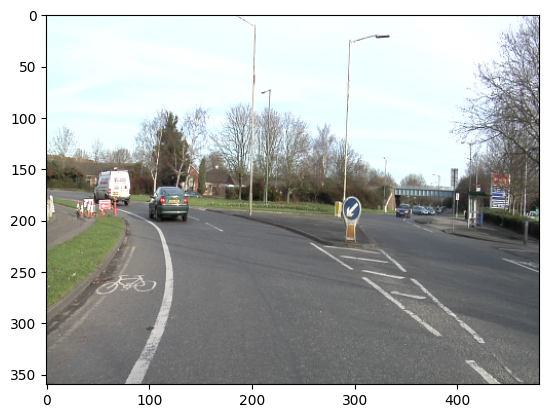

In [ ]:
plt.imshow(image)

In [ ]:
# preprocess mask
gt_mask = np.array(gt_mask)
gt_mask = (gt_mask == 3)
gt_mask = Image.fromarray(gt_mask)

# apply data augmentation
transform = Compose([
            Resize((224, 224)),
            ToTensor()
            ])

image = transform(image)

image = Compose([Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])])(image)

gt_mask = transform(gt_mask)

In [ ]:
model.eval()
output = model(image.view(1, 3, 224, 224).to("cuda")).cpu().detach().numpy()

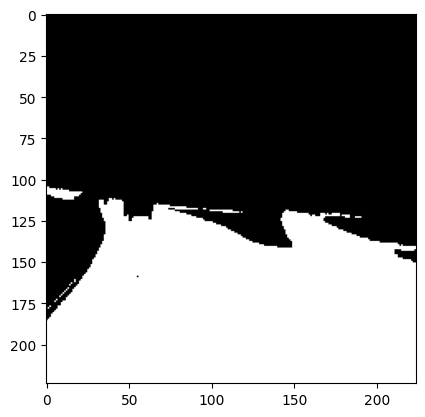

In [ ]:
plt.imshow(gt_mask.squeeze(), cmap='gray')

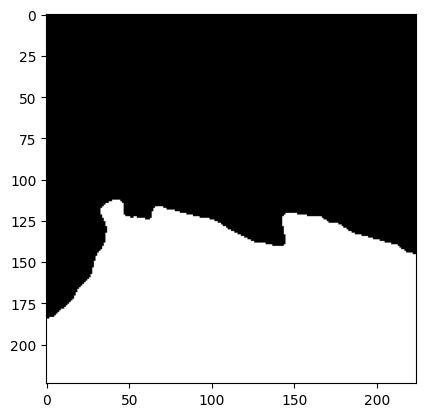

In [ ]:
plt.imshow((output.squeeze() > 0.5).astype(int), cmap='gray')

In [ ]:
# convert predicted mask to flattened numpy array
mask = (output.squeeze() > 0.5).astype(int)
pred = mask.ravel().copy()

# convert ground truth mask to flattened numpy array
gt_mask = gt_mask.cpu().detach().numpy()
target = gt_mask.ravel().copy().astype(int)

# get class indices for Lane
pred_inds = pred == 1
target_inds = target == 1

# calculate intersection
intersection = pred_inds[target_inds].sum()

# calculate union
union = pred_inds.sum() + target_inds.sum() - intersection

# get IoU score
iou = (float(intersection) / float(max(union, 1)))
iou

0.9691291585127202

#### 3.4 Inference on test dataset

In [ ]:
# run model for all images in test dataset
test_masks = []
model.eval()
with torch.no_grad():
    for test_image in test_dataset:
        mask = model(test_image.unsqueeze(0).to('cuda')).cpu().detach().numpy()
        test_masks.append(mask)

test_masks = (np.concatenate((test_masks), axis=0) > 0.5).astype(int)

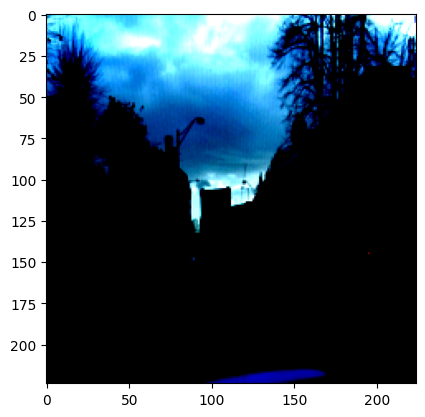

In [ ]:
# show original image
test_image = test_dataset[100]
plt.imshow(np.transpose(test_image, (1, 2, 0)))

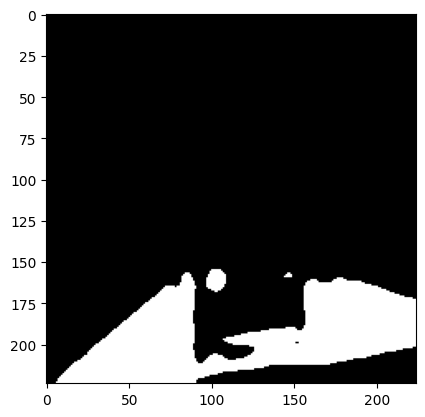

In [ ]:
# show prediction
plt.imshow((test_masks[100]).squeeze(), cmap='gray')